# Green AI model
### Dit model is gemaakt om te kunnen voorspellen in hoeverre de leefbaarheid, en het milieugezondheidsrisico van een postcode in Nederland verbeterd kan worden door het aanleggen van meer groen in de buurt.

 - Abel van Dijk

### Importeren van de data en libraries, en data analyseren

In [71]:
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import r2_score, mean_squared_error


In [60]:
# importeer de csv bestanden
Groenkaart = pd.read_csv('ai-data/Groenkaart.csv', sep=';')
Leefbaarometer = pd.read_csv('ai-data/Leefbaarometer.csv', sep=',')
Milieugezondheidrisico = pd.read_csv('ai-data/MilieuGezondheidRisico.csv', sep=',')
TreesBushesGrass = pd.read_csv('ai-data/TreesBushesGrass.csv', sep=',')
data = []
data.append(Groenkaart)
data.append(Leefbaarometer)
data.append(Milieugezondheidrisico)
data.append(TreesBushesGrass)

In [61]:
for dataframe in data:
    print(dataframe.head())

   fid  postcode groen_mean  groen_median groen_stdev  groen_min groen_max,,
0    1      1011          4             4           0          4         4,,
1    2      1012          4             4           0          4         4,,
2    3      1013          4             4           0          4         4,,
3    4      1014          4             4           0          4         4,,
4    5      1015          4             4           0          4         4,,
    PC4  jaar_van  jaar_naar       lbm  fys  onv  soc  vrz  won
0  1011      2002       2008  0.125362  NaN  NaN  NaN  NaN  NaN
1  1011      2002       2012  0.140800  NaN  NaN  NaN  NaN  NaN
2  1011      2002       2014  0.115708  NaN  NaN  NaN  NaN  NaN
3  1011      2002       2016  0.115027  NaN  NaN  NaN  NaN  NaN
4  1011      2002       2018  0.111637  NaN  NaN  NaN  NaN  NaN
   fid  postcode  aantal_inwoners  percentage_laag_inkomen_huishouden  \
0    1      1011             9910                              -99995   
1    2  

Alle dataframes bevatten een kolom met de postcode in pc4 format, (4 cijfers) en een kolom met de waarde van de variabele. De postcode in pc4 format is een unieke identifier voor elke postcode in Nederland. Dit betekent dat we de dataframes kunnen samenvoegen op basis van deze kolom.

### Samenvoegen van de dataframes


In [62]:
for i, df in enumerate(data):
    for col in df.columns:
        if col.lower() in ['postcode', 'pc4']:
            df.rename(columns={col: 'pc4'}, inplace=True)
    data[i] = df

merged_df = reduce(lambda left, right: pd.merge(left, right, on='pc4', how='outer'), data)

print(merged_df.head())

print(merged_df.columns)

   fid_x   pc4 groen_mean  groen_median groen_stdev  groen_min groen_max,,  \
0      1  1011          4             4           0          4         4,,   
1      1  1011          4             4           0          4         4,,   
2      1  1011          4             4           0          4         4,,   
3      1  1011          4             4           0          4         4,,   
4      1  1011          4             4           0          4         4,,   

   jaar_van  jaar_naar       lbm  ...  stedelijkheid  mgr_mean  mgr_median  \
0    2002.0     2008.0  0.125362  ...              1  7.290559    7.133442   
1    2002.0     2012.0  0.140800  ...              1  7.290559    7.133442   
2    2002.0     2014.0  0.115708  ...              1  7.290559    7.133442   
3    2002.0     2016.0  0.115027  ...              1  7.290559    7.133442   
4    2002.0     2018.0  0.111637  ...              1  7.290559    7.133442   

   mgr_stdev   mgr_min    mgr_max  mgr_range  PercentageTrees 

### Missende data

In [63]:
missing_data = merged_df.isnull().sum()
missing_data_percentage = (missing_data / len(merged_df)) * 100
missing_data_percentage = missing_data_percentage[missing_data_percentage > 0]
print(missing_data_percentage)

jaar_van      0.014188
jaar_naar     0.014188
lbm           0.014188
fys          78.523228
onv          78.523228
soc          78.523228
vrz          78.523228
won          78.523228
dtype: float64


### Verwijderen van onnodige kolommen
- fid_x en fid_y slechts een id, kan verwijderd worden
Leefbaarheid wordt gevormd door
- Woningvoorraad
- Fysieke omgeving
- Voorzieningen
- Sociale samenhang
- Overlast en onveiligheid
Deze subvariabelen zijn in de meeste rijen niet ingevuld, en zijn dus niet handig om te gebruiken. We verwijderen ze.

- jaar_van en jaar_naar zijn niet nodig omdat de AI geen tijdsafhankelijk is.

-lbm (Leefbaarometer) is een waarde die we willen vorspellen, en is dus de target variable. Deze kolom willen we behouden, daarom verwwijder ik de rijen met een null waarde in deze kolom.

In [64]:
# Verwijder de kolommen die niet nodig zijn
merged_df.drop(columns=['fid_x', 'fid_y', 'fys', 'onv', 'soc', 'vrz', 'won', 'jaar_naar', 'jaar_van'], inplace=True)

# Verwijder de rijen met een null waarde in de kolom 'lbm'
merged_df.dropna(subset=['lbm'], inplace=True)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112757 entries, 0 to 112772
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   pc4                                 112757 non-null  int64  
 1   groen_mean                          112757 non-null  object 
 2   groen_median                        112757 non-null  int64  
 3   groen_stdev                         112757 non-null  object 
 4   groen_min                           112757 non-null  int64  
 5   groen_max,,                         112757 non-null  object 
 6   lbm                                 112757 non-null  float64
 7   aantal_inwoners                     112757 non-null  int64  
 8   percentage_laag_inkomen_huishouden  112757 non-null  int64  
 9   omgevingsadressendichtheid          112757 non-null  int64  
 10  stedelijkheid                       112757 non-null  int64  
 11  mgr_mean                       

### Niet-numerieke kolommen
de kolommen groen_mean, groen_stdev, groen_max bevatten bevatten objects in plaats van floats. bij het bekijken van de data zie ik dat er een fout lijkt te zijn, omdat de waarden van 1 tot 4 horen te zijn, maar enorme waarden bevatten. Dit komt omdat de kaart -9999 bevat op locaties waar geen groen is. de waarden 1 tot 4 zijn categorisch. Bij het berekenen van het gemiddelde, standaard deviatie en maximum, worden dus vreemde getallen berekend. Ik denk dat dit komt omdat Qgis niet goed kan rekenen met de -9999 waarde. Omdat de meeste rijen nu hele rare data bevatten, verwijder ik deze kolommen.

Omdat het categorische data betreft, lijkt de Median

In [65]:
# delete the columns groen_mean;groen_median;groen_stdev;groen_min;groen_max,

merged_df.drop(columns=['groen_mean', 'groen_median', 'groen_stdev', 'groen_min', 'groen_max,,'], inplace=True)

merged_df.describe()

,pc4,lbm,aantal_inwoners,percentage_laag_inkomen_huishouden,omgevingsadressendichtheid,stedelijkheid,mgr_mean,mgr_median,mgr_stdev,mgr_min,mgr_max,mgr_range,PercentageTrees,PercentageBushes,PercentageGrass
count,112757.000000,112757.000000,112757.000000,112757.0,112757.000000,112757.000000,112757.000000,112757.000000,112757.000000,112757.000000,112757.000000,112757.000000,112757.000000,112757.000000,112757.000000
mean,5683.657414,0.027117,4251.471075,-99995.0,1080.766267,3.736291,4.111463,3.933553,0.624156,3.069564,8.062582,4.993018,32.656208,8.698239,47.525149
std,2664.755687,0.063354,6066.047278,0.0,1425.821055,1.464727,1.053588,0.991937,0.321707,1.337337,2.430716,2.293558,11.459565,1.580098,10.943012
min,1011.000000,-0.837495,-99997.000000,-99995.0,2.000000,1.000000,2.019631,2.552323,0.047456,0.000000,3.111541,0.339382,3.810000,4.010000,13.890000
25%,3344.000000,-0.004805,750.000000,-99995.0,125.000000,2.000000,3.312202,3.191154,0.387390,2.743936,6.402481,3.408285,24.420000,7.780000,39.530000
50%,5712.000000,0.023438,2860.000000,-99995.0,530.000000,4.000000,3.867836,3.679556,0.577447,3.219712,7.759542,4.640089,29.550000,8.460000,47.240000
75%,8051.000000,0.057576,7200.000000,-99995.0,1572.000000,5.000000,4.726688,4.492579,0.801748,3.791558,9.329633,6.147729,40.040000,9.290000,55.800000
max,9999.000000,0.847029,28185.000000,-99995.0,11760.000000,5.000000,13.014039,12.994216,3.122285,7.863830,21.830309,17.693716,70.450000,23.060000,91.490000


### relaties vinden tussen de variabelen
Het kan zijn dat er simpele correlaties zijn tussen de variabelen. Dit kan helpen om te begrijpen hoe de data in elkaar steekt, en kan ook helpen om de AI beter te maken. We gaan kijken naar de correlatie tussen de variabelen.

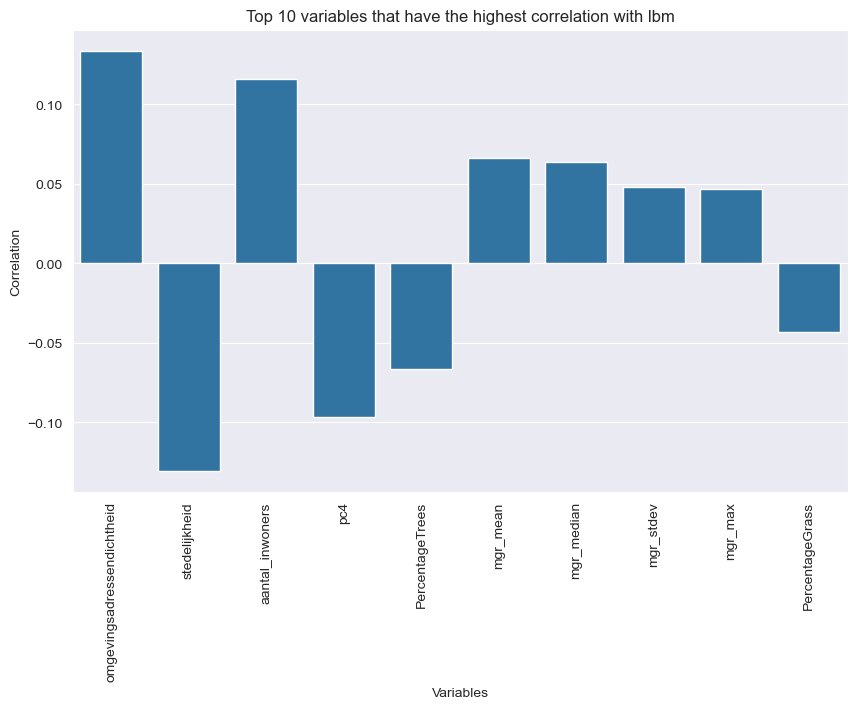

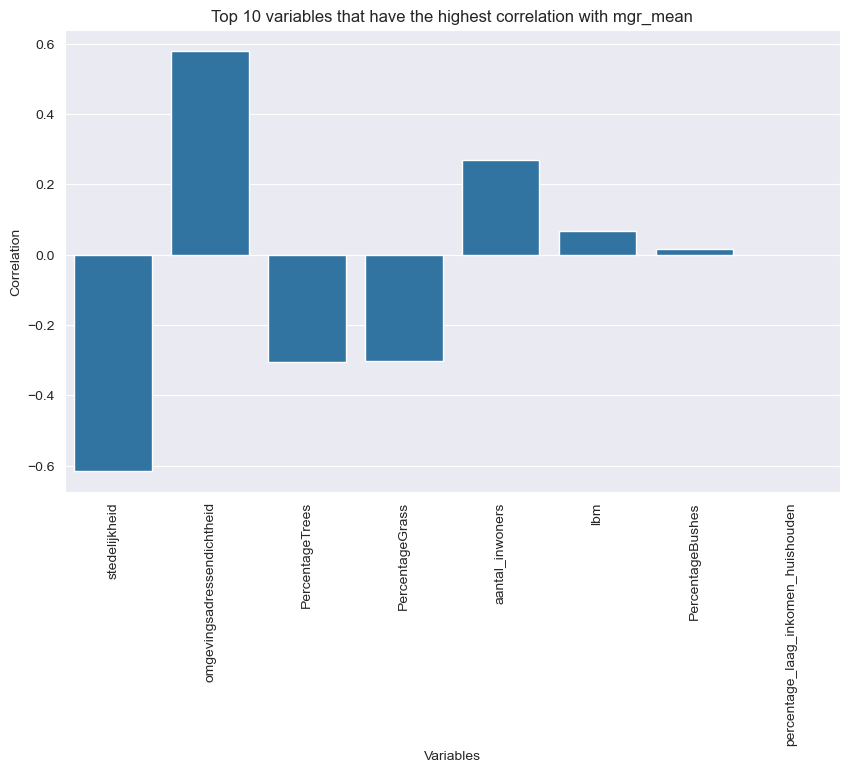

In [66]:
# print the top 10 of variables that have the highest correlation with lbm
correlation = merged_df.corr()
correlation = correlation['lbm']
correlation = correlation.reindex(correlation.abs().sort_values(ascending=False).index)
correlation = correlation[1:11]
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.xticks(rotation=90)
plt.title('Top 10 variables that have the highest correlation with lbm')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.show()

# print the top 10 of variables that have the highest correlation with mgr_mean
exclude = ['mgr_median', 'mgr_stdev', 'mgr_min', 'mgr_max', 'mgr_range', 'pc4']
temp_df = merged_df.drop(columns=exclude)
correlation = temp_df.corr()
correlation = correlation['mgr_mean']
correlation = correlation.reindex(correlation.abs().sort_values(ascending=False).index)
correlation = correlation[1:11]
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.xticks(rotation=90)
plt.title('Top 10 variables that have the highest correlation with mgr_mean')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.show()

We zien hier dat de variabelen: omgevingsadressendichtheid, en stedelijkheid de hoogste correlatie hebben met de leefbaarometer. Echter zijn deze scores niet hoog. Ongeveer 0.15.

Het Milieugezondheidsrisico lijkt betere correlaties te hebben. De Stedelijkheid en omgevingsgeadressendichtheid hebben een correlatie van ongeveer 0.6.

Deze correlaties zijn echter niet erg nuttig voor het model, we willen namelijk zien wat de impact is van kleine veranderingen die gewone burgers kunnen uitvoeren, zoals het planten van struiken en gras. Daarom gaan we de data verder analyseren met minder kolommen.


In [67]:
print(merged_df.columns)
drop_columns = ['aantal_inwoners', 'percentage_laag_inkomen_huishouden', 'omgevingsadressendichtheid', 'mgr_median', 'mgr_stdev', 'mgr_min', 'mgr_max', 'mgr_range']
merged_df = merged_df.drop(columns=drop_columns)

# create a svm model to predict the lbm (leefbaarometer) and mgr_mean based on the other variable

X = merged_df.drop(columns=['lbm', 'mgr_mean', 'pc4'])
y_lbm = merged_df['lbm']
y_mgr = merged_df['mgr_mean']
X_train, X_test, y_train_lbm, y_test_lbm = train_test_split(X, y_lbm, test_size=0.2, random_state=42)
X_train_mgr, X_test_mgr, y_train_mgr, y_test_mgr = train_test_split(X, y_mgr, test_size=0.2, random_state=42)

model = svm.SVR(kernel='linear')
model.fit(X_train, y_train_lbm)
y_pred_lbm = model.predict(X_test)
model_mgr = svm.SVR(kernel='linear')
model_mgr.fit(X_train_mgr, y_train_mgr)
y_pred_mgr = model_mgr.predict(X_test_mgr)

# show results


Index(['pc4', 'lbm', 'aantal_inwoners', 'percentage_laag_inkomen_huishouden',
       'omgevingsadressendichtheid', 'stedelijkheid', 'mgr_mean', 'mgr_median',
       'mgr_stdev', 'mgr_min', 'mgr_max', 'mgr_range', 'PercentageTrees',
       'PercentageBushes', 'PercentageGrass'],
      dtype='object')


In [70]:
joblib.dump(model, 'svm_lbm_model.joblib')
joblib.dump(model_mgr, 'svm_mgr_model.joblib')

['svm_mgr_model.joblib']

In [72]:
# Test lbm model
r2_lbm = r2_score(y_test_lbm, y_pred_lbm)
mse_lbm = mean_squared_error(y_test_lbm, y_pred_lbm)
print(f'lbm model - R²: {r2_lbm:.3f}, MSE: {mse_lbm:.3f}')

# Test mgr_mean model
r2_mgr = r2_score(y_test_mgr, y_pred_mgr)
mse_mgr = mean_squared_error(y_test_mgr, y_pred_mgr)
print(f'mgr_mean model - R²: {r2_mgr:.3f}, MSE: {mse_mgr:.3f}')

lbm model - R²: 0.015, MSE: 0.004
mgr_mean model - R²: 0.386, MSE: 0.677
